# The Simple Framework of Choice

*Appendix to my Bachelor Thesis.*

In this file we reproduce a pulse-coupled neural networks simulation (PCNN) introduced by E. Izhikevich in his paper ["Simple model of spiking neurons"](http://www.izhikevich.org/publications/spikes.pdf) to demonstrate the power of his simple model.  
We adapt the MATLAB code to our simple framework of choice and compare the two implementations.

In [3]:
# Imports
import timeit
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *

In [6]:
def brian_implementation_PCNN(def_clock=None, plotit=True):
    start_scope()
    
    # for timing puprposes
    if def_clock:
        # 0.1*ms by default
        defaultclock.dt = def_clock*ms
        
    tau  = 1*ms; sigma = 1
    Ne = 800
    excitatory_eq =\
    '''
    re : 1
    a = 0.02 : 1 (shared)
    b = 0.2 : 1 (shared)
    c = -65 + 15*re**2 : 1
    d = 8 - 6*re**2 : 1
    
    dv/dt = (0.04*v**2 + 5*v + 140 - u)/tau + 5*sigma*xi*sqrt(1/tau)   : 1
    du/dt = a*(b*v - u)/tau : 1
    '''
    Ni = 200
    inhibitory_eq =\
    '''
    ri : 1
    a = 0.02 + 0.08*ri : 1
    b = 0.25 - 0.05*ri : 1
    c = -65 : 1 (shared)
    d = 2 : 1 (shared)
    
    dv/dt = (0.04*v**2 + 5*v + 140 - u)/tau + 2*sigma*xi*sqrt(1/tau) : 1
    du/dt = a*(b*v - u)/tau : 1
    '''
    reset =\
    '''
    v = c
    u += d
    '''
    vpeak = 30
    peak_threshold = 'v>vpeak'

    excitatory_group = NeuronGroup(Ne, excitatory_eq, threshold=peak_threshold, reset=reset, method='euler')
    # initialisations
    excitatory_group.v = -65
    excitatory_group.u = excitatory_group.b * excitatory_group.v
    excitatory_group.re = 'rand()'
    # Monitors
    excitatory_spikemon = SpikeMonitor(excitatory_group)
    excitatory_statemon = StateMonitor(excitatory_group, 'v' ,record=0)
    
    inhibitory_group = NeuronGroup(Ni, inhibitory_eq, threshold=peak_threshold, reset=reset, method='euler')
    # Initialisations
    inhibitory_group.v = -65
    inhibitory_group.u = inhibitory_group.b * inhibitory_group.v
    inhibitory_group.ri = 'rand()'
    # Monitors
    inhibitory_spikemon = SpikeMonitor(inhibitory_group)
    
    # Synapses
    S_EtoE = Synapses(excitatory_group, excitatory_group, 'w : 1', on_pre='v_post += 0.5*w')
    S_EtoE.connect()
    S_EtoE.w = 'rand()'
    
    S_EtoI = Synapses(excitatory_group, inhibitory_group, 'w : 1', on_pre='v_post += 0.5*w')
    S_EtoI.connect()
    S_EtoI.w = 'rand()'
    
    S_ItoI = Synapses(inhibitory_group, inhibitory_group, 'w : 1', on_pre='v_post -= 1*w')
    S_ItoI.connect()
    S_ItoI.w = 'rand()'
    
    S_ItoE = Synapses(inhibitory_group, excitatory_group, 'w : 1', on_pre='v_post -= 1*w')
    S_ItoE.connect()
    S_ItoE.w = 'rand()'
    
#     # uncomment to disable synapses
#     S_EtoE.w = 0
#     S_EtoI.w = 0
#     S_ItoI.w = 0
#     S_ItoE.w = 0
    
    # Run
    run(1000*ms)
    
    if not plotit:
        return
    # Plot
    fig, ((ax1), (ax2)) = subplots(2, 1, 'all', gridspec_kw={'height_ratios': [3.2, 0.8], 'hspace': 0}, figsize=(8,10))
    
    ax1.set_title('Spike Raster Plot')
    ax1.plot(
        concatenate([excitatory_spikemon.t/ms, inhibitory_spikemon.t/ms]),
        concatenate([excitatory_spikemon.i, 800 + inhibitory_spikemon.i]), ',k')
    ax1.plot(arange(1000), ones(1000)*800, '-k', lw=1)
    ax1.set_ylabel('Neuron index')
    
    ax2.plot(excitatory_statemon.t/ms, excitatory_statemon.v[0], linewidth=0.75)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('$v_0(t)$')
    ax2.set_ylim([-90, 40])
    fig.savefig('figures/PCNN_brian.png')
    

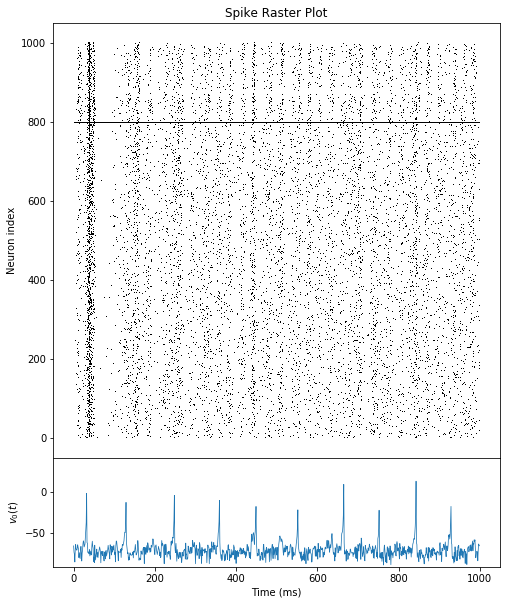

In [48]:
brian_implementation_PCNN()

In [49]:
def MATLAB_adaptation_PCNN(plotit=True):
    """
    Adapted from Eugene M. Izhikevich, February 25, 2003
    Formatted as the original file
    """
    
    # Excitatory neurons                               Inhibitory neurons
    Ne = 800;                                          Ni = 200
    re = np.random.rand(Ne);                           ri = np.random.rand(Ni)
    a = np.concatenate([0.02*np.ones(Ne),              0.02+0.08*ri])
    b = np.concatenate([0.2*np.ones(Ne),               0.25-0.05*ri])
    c = np.concatenate([-65+15*re**2,                  -65*np.ones(Ni)])
    d = np.concatenate([8-6*re**2,                     2*np.ones(Ni)])
    S = np.concatenate([0.5*np.random.rand(Ne+Ni,Ne),  -np.random.rand(Ne+Ni,Ni)], axis=1)

    v = -65*np.ones(Ne+Ni)     # Initial values of v
    u = b*v                    # Initial values of u
    firings = []               # spike timings
    firing_times = []
    first_neuron = [v[0]]
    
    for t in range(1,1000):                                                   # simulation of 1000 ms
        I = np.concatenate([5*np.random.randn(Ne), 2*np.random.randn(Ni)])    # thalamic input
        fired = np.nonzero(v >= 30)[0]                                        #  indices of spikes
        firings.extend(fired)
        firing_times.extend(t + 0*fired)
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]
        I = I + np.sum(S[:,fired], axis=1)
        v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)    # step 0.5 ms
        v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)    # for numerical
        u = u + a*(b*v - u)                            # stability
        first_neuron.append(v[0])
        

    if not plotit:
        return
    # Plot
    fig, ((ax1), (ax2)) = subplots(2, 1, 'all', gridspec_kw={'height_ratios': [3.2, 0.8], 'hspace': 0}, figsize=(8,10))

    ax1.set_title('Spike Raster Plot')
    ax1.plot(firing_times, firings, ',k')
    ax1.plot(np.arange(1000), np.ones(1000)*800, '-k', lw=1)
    ax1.set_ylabel('Neuron index')
    
    ax2.plot(np.arange(1000), first_neuron, linewidth=0.75)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('$v_0(t)$')
    ax2.set_ylim([-90, 40])

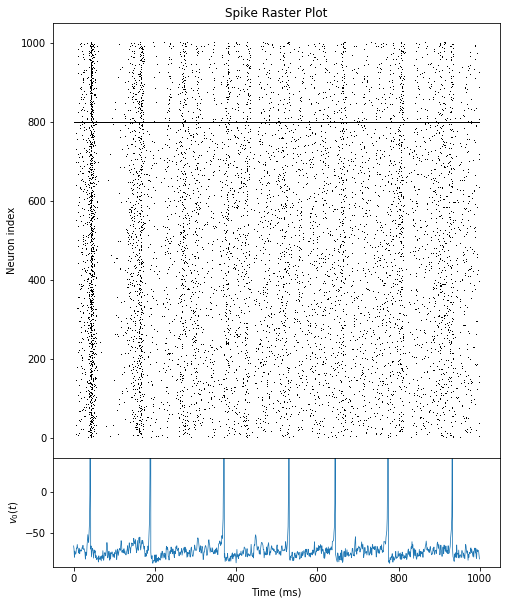

In [50]:
MATLAB_adaptation_PCNN()

In [57]:
# Comparison
def brian_implementation_1ms_clock():
    return brian_implementation_PCNN(def_clock=1, plotit=False)

def manual_implementation_1ms_clock():
    return MATLAB_adaptation_PCNN(plotit=False)
N = 20
brian_time = timeit.timeit(brian_implementation_1ms_clock, number=N)/N
manual_time = timeit.timeit(manual_implementation_1ms_clock, number=N)/N

print(brian_time, manual_time)

0.649399101500012 0.25119415045001003


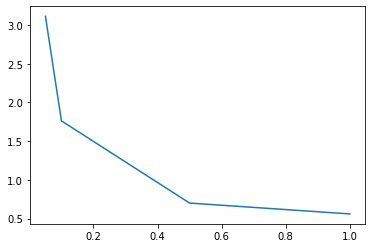

In [55]:
# brian scale time
def brian_implementation_timing():
    
    timing = []
    clock_steps = [0.05, 0.1, 0.5, 1]
    
    for clock in clock_steps:
        def wrapper():
            return brian_implementation_PCNN(def_clock=clock, plotit=False)
        timing.append(timeit.timeit(wrapper, number=1))
    
    plt.plot(clock_steps, timing)
    
brian_implementation_timing()